In [12]:
# libraries

import torch
import torch.nn as nn
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.optim as optim

import os#??
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import time #??

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.dpi']=600
torch.set_default_dtype(torch.float)
torch.manual_seed(5113628)

mydevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(mydevice)

if mydevice == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [13]:
#bounds
x_min=0
x_max=20
t_min = 0
t_max = 5
steps = 20000

total_points = 200

ext = [t_min,t_max,x_min,x_max]

#different loss terms
labels_list=[]
physics_list=[]
lamda1_list=[]
lamda2_list=[]

In [14]:
# Prepare data
def kdv2(c1,c2,t,x):
    xi1 = x - c1*t+2
    xi2 = x - c2*t-6
    return (2*(c1-c2)*(c1*torch.cosh(0.5*xi2*(c2**0.5))**2+c2*torch.sinh(0.5*xi1*(c1**0.5))**2))/torch.square(((c1**0.5)-(c2**0.5))*torch.cosh(0.5*(xi1*(c1**0.5)+xi2*(c2**0.5)))+((c1**0.5)+(c2**0.5))*torch.cosh(0.5*(xi1*(c1**0.5)-xi2*(c2**0.5))))

c1=6;c2=2

x=torch.linspace(x_min,x_max,total_points).view(-1,1)
t=torch.linspace(t_min,t_max,total_points).view(-1,1)
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))

u = kdv2(c1,c2,T,X).float().to(mydevice) #solution


err = np.random.uniform(low=0.9, high=1.1, size=(total_points*total_points,1)) #noise
err = torch.from_numpy(err).float().to(mydevice) 

In [15]:
layer = [2,20,20,20,20,20,20,20,20,1]
activations = [nn.Tanh,nn.Tanh,nn.Tanh,nn.Tanh,nn.Tanh,nn.Tanh,nn.Tanh,nn.Tanh,'off']
len(layer)

10

In [16]:
def NN(layer,activations):
    layers = []
    for i in range(len(layer)-1):
        layers.append(nn.Linear(layer[i], layer[i+1]))
        if activations[i] == 'off':
            pass
        else:
            layers.append(activations[i]())
    return nn.Sequential(*layers)


In [17]:
#create grid
t_physics = torch.linspace(t_min,t_max,total_points).repeat_interleave(total_points).view(-1,1).to(mydevice)
x_physics = torch.linspace(x_min,x_max,total_points).repeat(total_points,1).view(-1,1).to(mydevice)
x_physics.requires_grad_(True)
t_physics.requires_grad_(True)
Xtrain = torch.cat([x_physics,t_physics],axis=1).to(mydevice)


In [18]:
model = NN(layer,activations)
model.to(mydevice)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Tanh()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): Tanh()
  (12): Linear(in_features=20, out_features=20, bias=True)
  (13): Tanh()
  (14): Linear(in_features=20, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=1, bias=True)
)

In [19]:
#implementation using Adam or L-BFGS
def adam():
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7000], gamma=0.1) #adaptive learning rate
    for i in range(steps):
        #Pytorch accumulates gradients during training, so set to zero before optimization step
        optimizer.zero_grad()
        mse = nn.MSELoss()
        
        up = model(Xtrain) #prediction
        uerr = err*kdv2(c1,c2,t_physics,x_physics) #noisy data

        u_t = torch.autograd.grad(up,t_physics,torch.ones_like(t_physics), create_graph=True)[0] #du/dt
        u_x = torch.autograd.grad(up,x_physics,torch.ones_like(x_physics), create_graph=True)[0] #du/dx
        u_xx = torch.autograd.grad(u_x,x_physics,torch.ones_like(x_physics), create_graph=True)[0] #du^2/dx^2
        u_xxx = torch.autograd.grad(u_xx,x_physics,torch.ones_like(x_physics), create_graph=True)[0] #du^3/dx^3
        
        physics = u_t + 6*up*u_x + u_xxx #residue KdV equation with model parameter beta
        zeros = torch.zeros(Xtrain.shape[0],1).to(mydevice)
        physics_loss = mse(physics,zeros)
        labels = mse(up,uerr)
        
        total_loss = physics_loss + labels

        physics_list.append(physics_loss.detach().cpu().numpy())
        labels_list.append(labels.detach().cpu().numpy())
        
        total_loss.backward() #backward propagation
        torch.nn.utils.clip_grad_norm_(model.parameters(),1) #enable clipping
        optimizer.step() #perform one optimization step
        scheduler.step() #update learning rate as specified by condition set in scheduler
        if i % 1000 ==0:
            print(i,'/',steps)
"""
def bfgs(): 
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-2, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
            
        mse = nn.MSELoss()
        up = model(Xtrain)
        
        uerr = err*kdv2(c1,c2,t_physics,x_physics)

        u_t = torch.autograd.grad(up,t_physics,torch.ones_like(t_physics), create_graph=True)[0]
        u_x = torch.autograd.grad(up,x_physics,torch.ones_like(x_physics), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x,x_physics,torch.ones_like(x_physics), create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx,x_physics,torch.ones_like(x_physics), create_graph=True)[0]
        
        physics = u_t + lamda1*up*u_x + lamda2*u_xxx
        zeros = torch.zeros(Xtrain.shape[0],1).to(mydevice)
        physics_loss = mse(physics,zeros)
        labels = mse(up,uerr)
        total_loss = physics_loss + labels

        physics_list.append(physics_loss.detach().cpu().numpy())
        labels_list.append(labels.detach().cpu().numpy())
        lamda1_list.append(lamda1[0].detach().cpu().numpy())
        lamda2_list.append(lamda2[0].detach().cpu().numpy())
        total_loss.backward()

        return total_loss

    optimizer.step(closure)
"""

"\ndef bfgs(): \n    optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-2, \n                              max_iter = steps, \n                              max_eval = None, \n                              tolerance_grad = 1e-05, \n                              tolerance_change = 1e-09, \n                              history_size = 100, \n                              line_search_fn = 'strong_wolfe')\n\n    def closure():\n        if torch.is_grad_enabled():\n            optimizer.zero_grad()\n            \n        mse = nn.MSELoss()\n        up = model(Xtrain)\n        \n        uerr = err*kdv2(c1,c2,t_physics,x_physics)\n\n        u_t = torch.autograd.grad(up,t_physics,torch.ones_like(t_physics), create_graph=True)[0]\n        u_x = torch.autograd.grad(up,x_physics,torch.ones_like(x_physics), create_graph=True)[0]\n        u_xx = torch.autograd.grad(u_x,x_physics,torch.ones_like(x_physics), create_graph=True)[0]\n        u_xxx = torch.autograd.grad(u_xx,x_physics,torch.ones_lik

In [ ]:
start = time.time()
adam() #choose optimization algorithm
end = time.time()
print('elapsed time:',end - start,'s')

#amount of prediction data
ntpredict=200
nxpredict=200

0 / 20000
1000 / 20000
2000 / 20000
3000 / 20000
4000 / 20000
5000 / 20000
6000 / 20000
7000 / 20000
8000 / 20000
9000 / 20000
10000 / 20000
11000 / 20000
12000 / 20000
13000 / 20000
14000 / 20000
15000 / 20000
16000 / 20000
17000 / 20000
18000 / 20000
19000 / 20000
elapsed time: 18720.217964172363 s


MSE: 3.854462192975916e-06
MSE labels: 0.001299832
physics loss: 2.3068056e-05


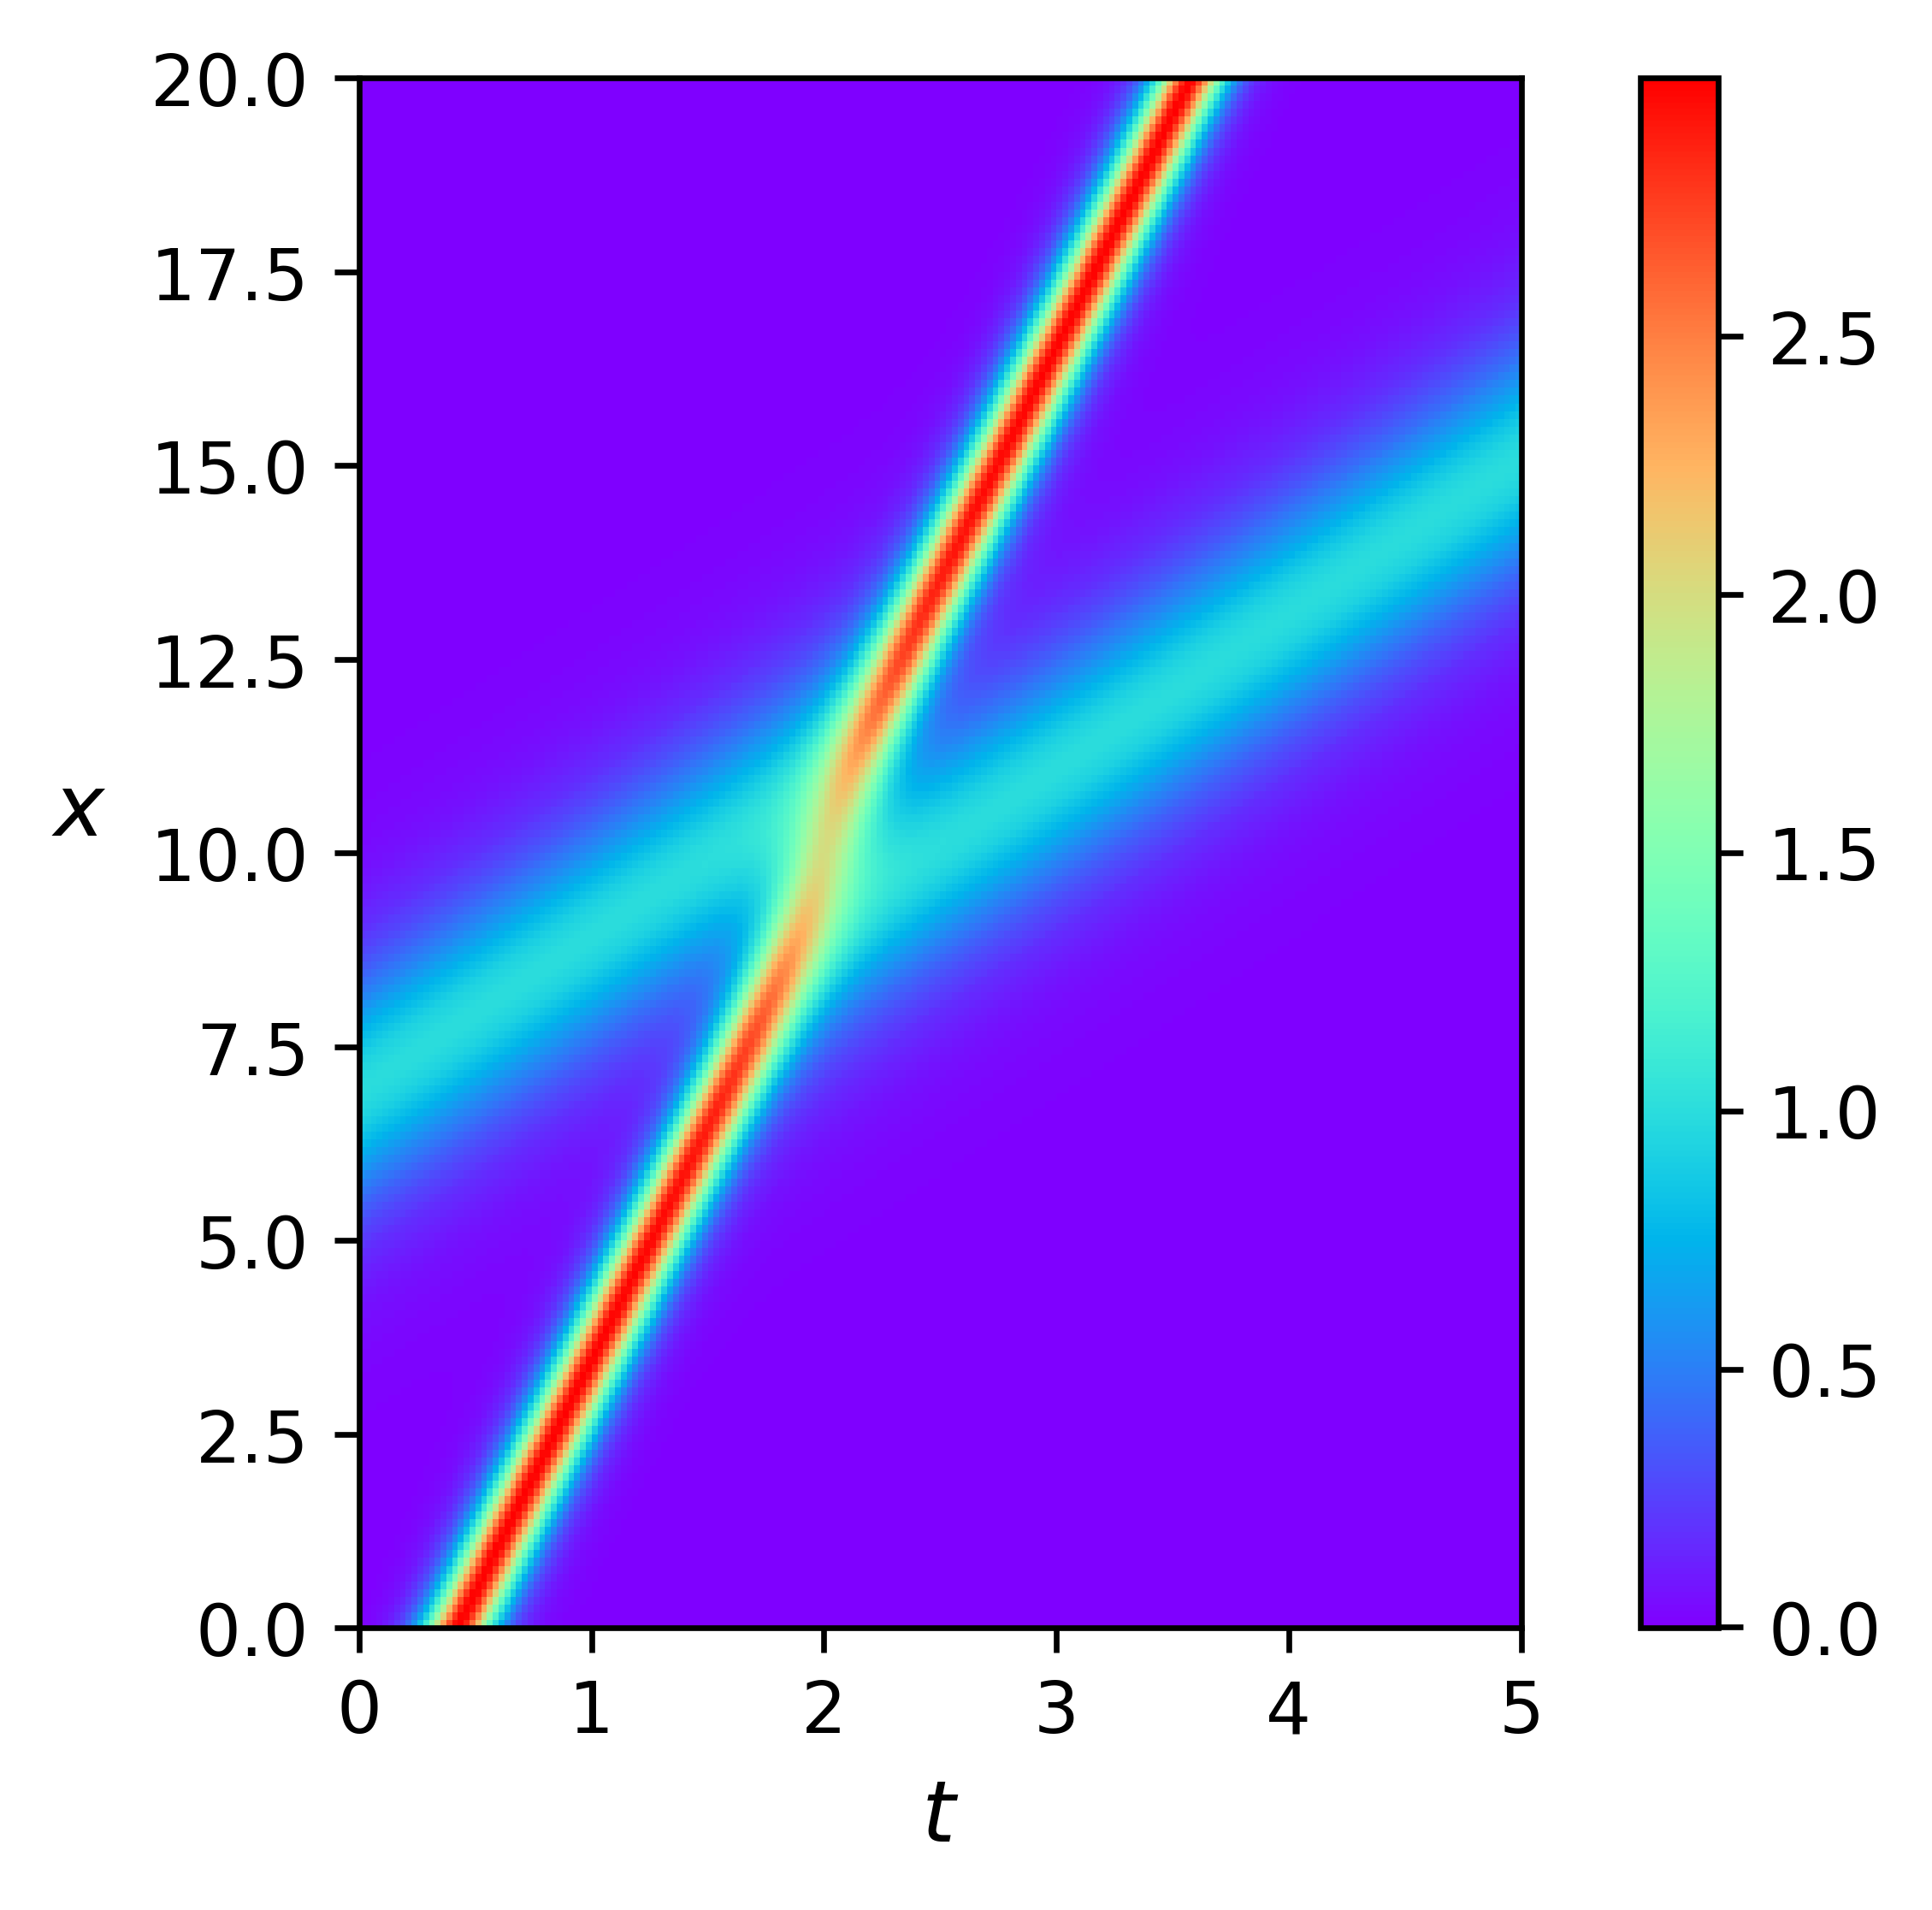

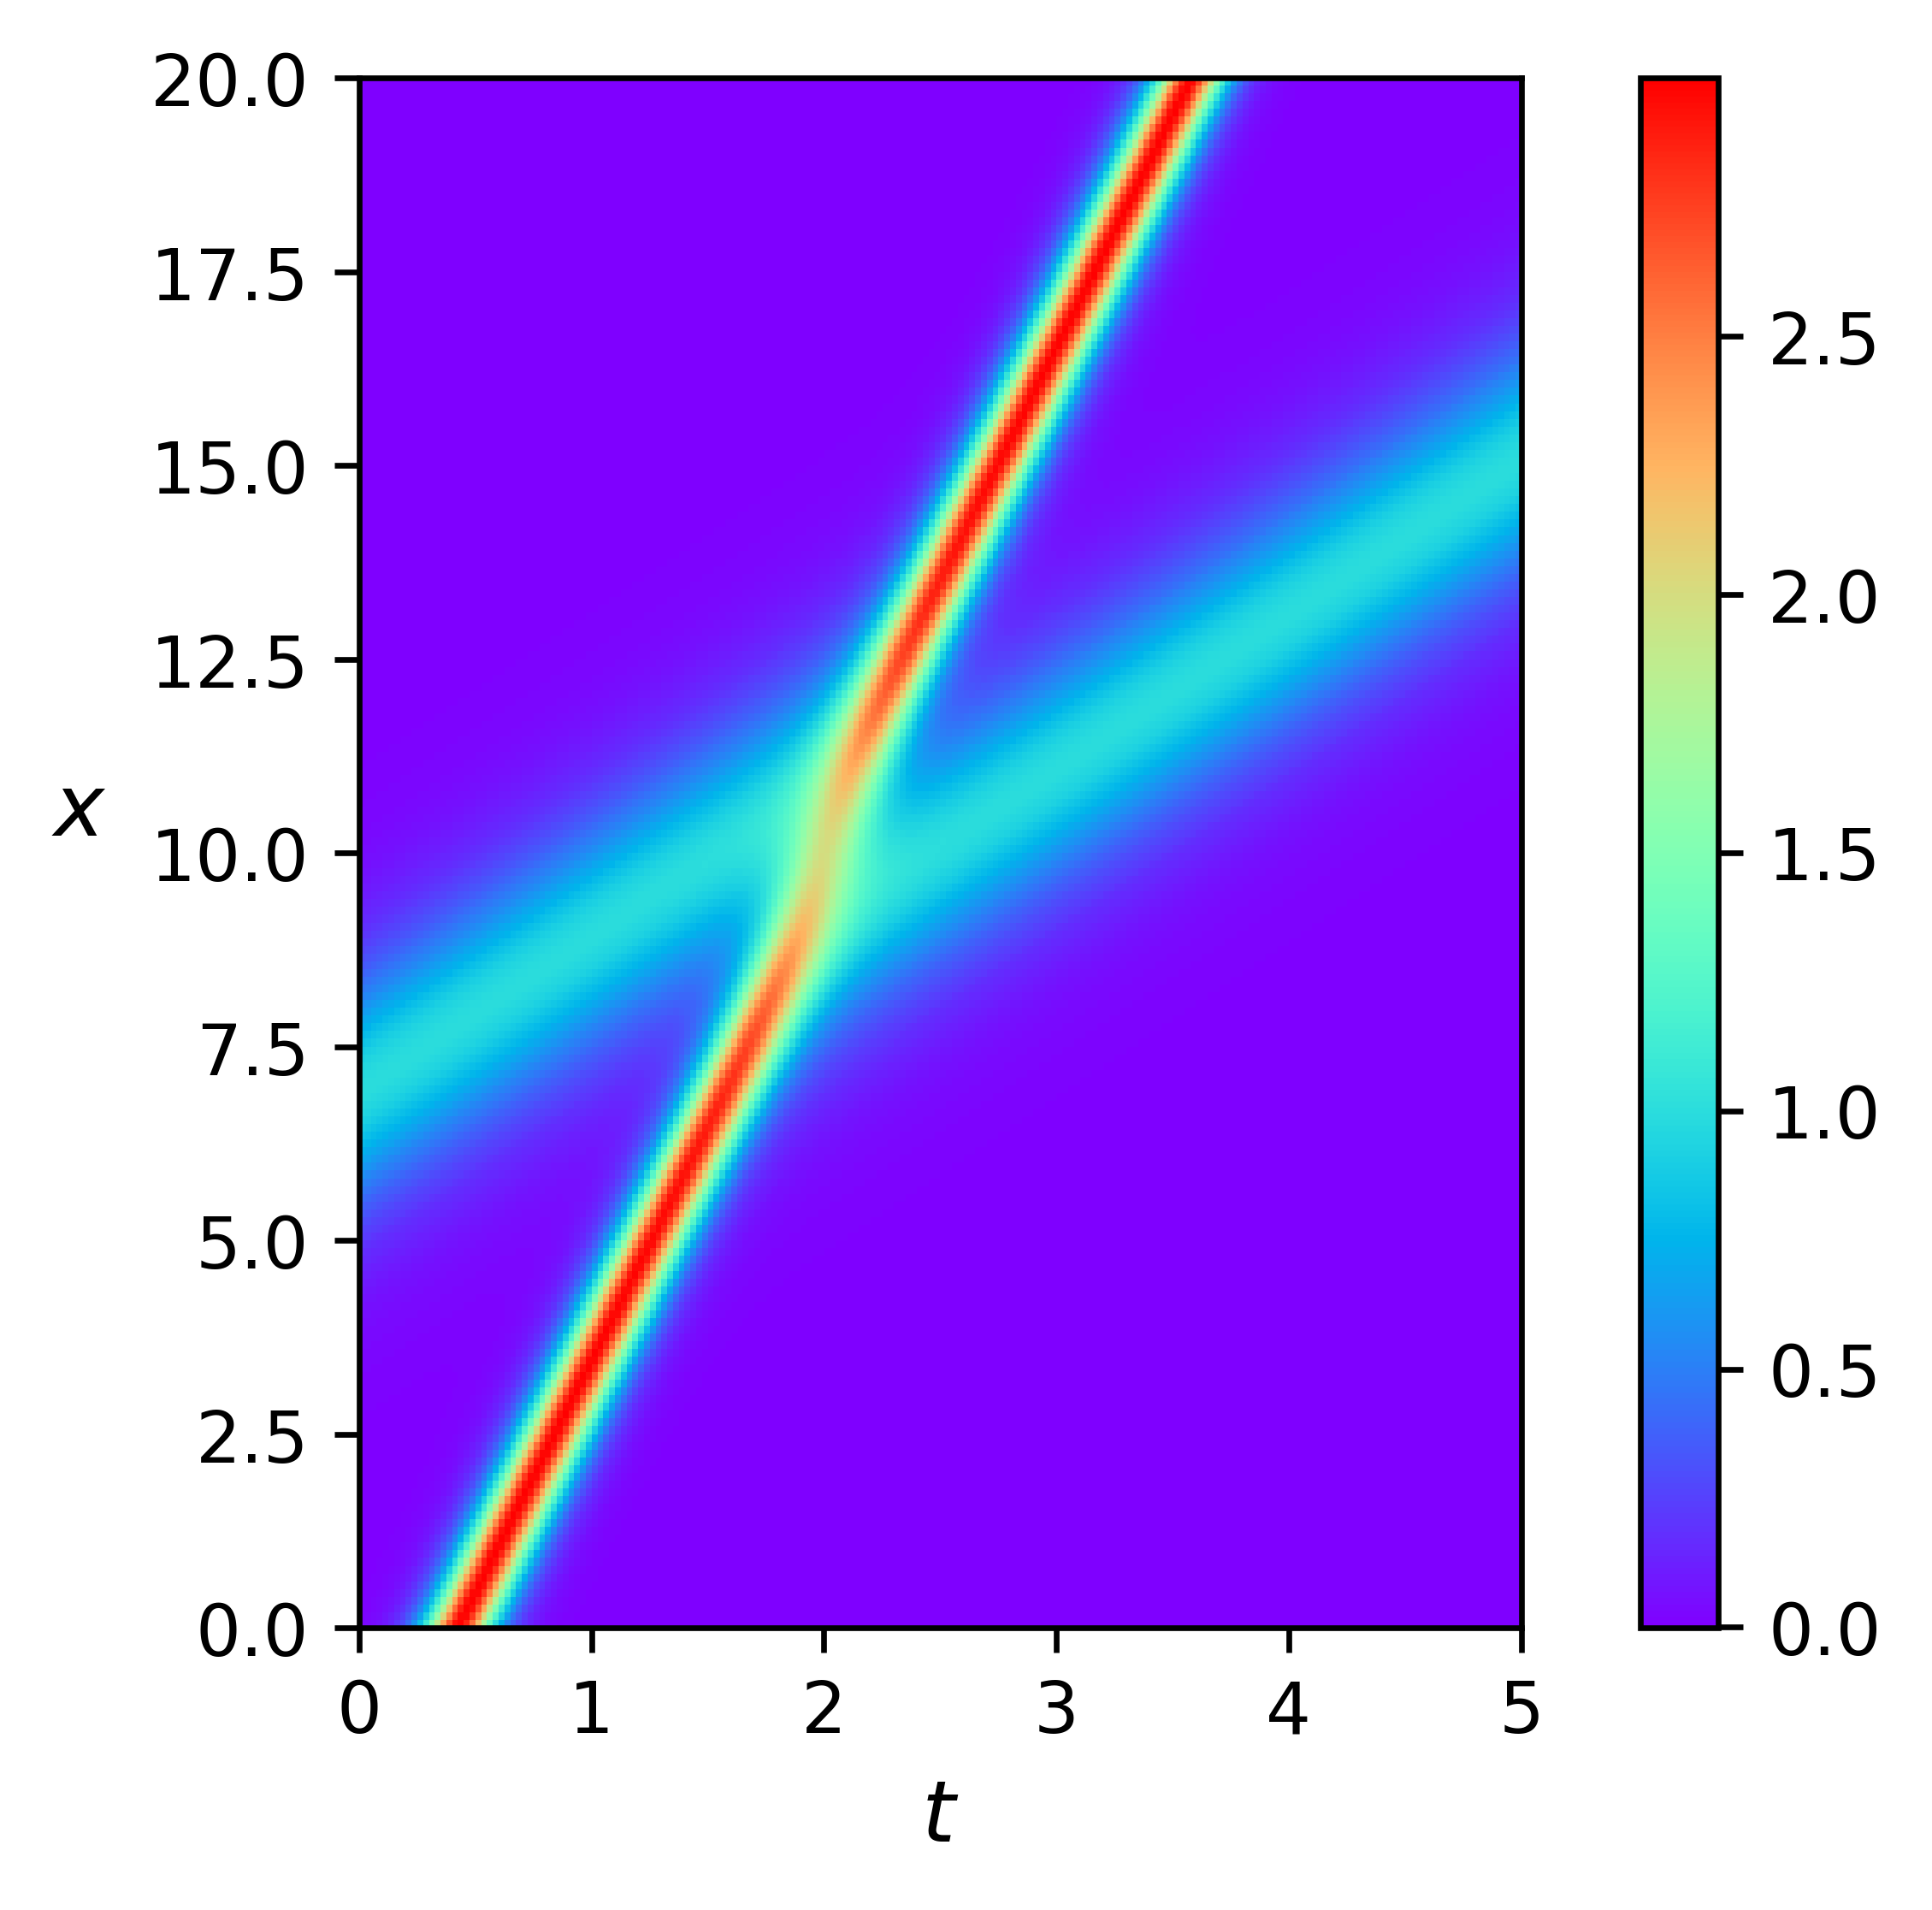

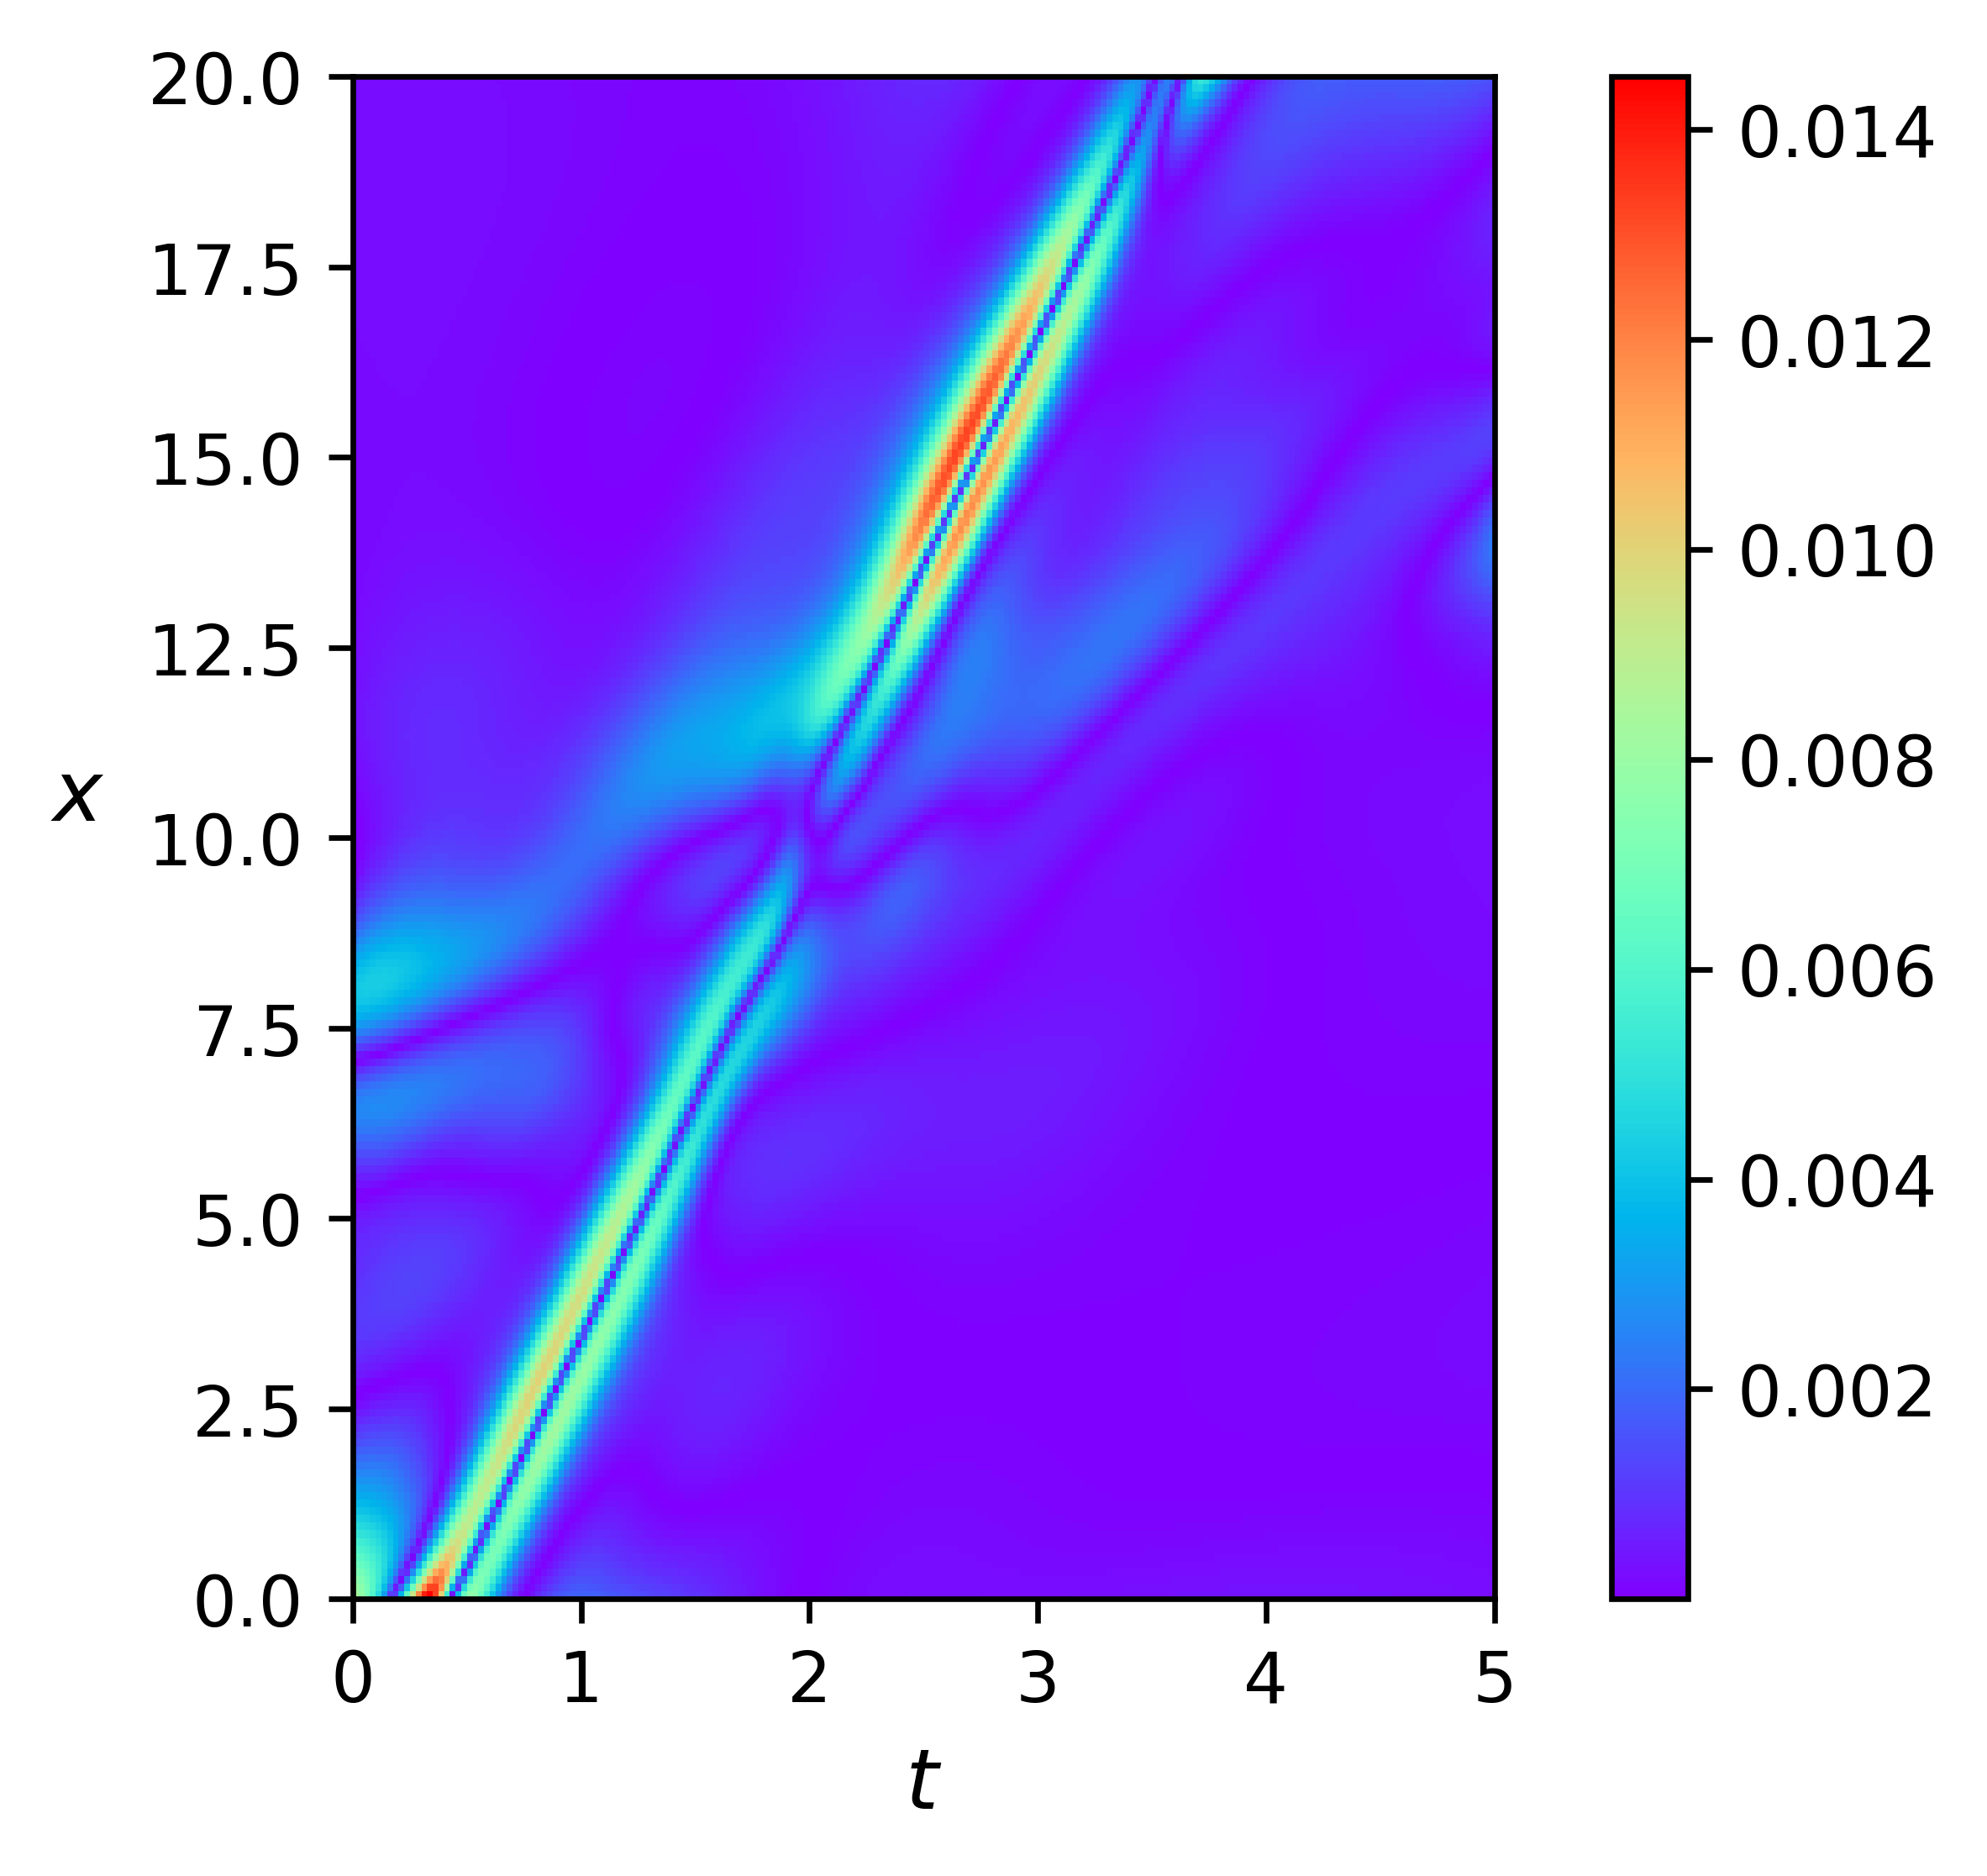

In [ ]:
#predict
t_predict = torch.linspace(t_min,t_max,ntpredict).repeat_interleave(nxpredict).view(-1,1)
x_predict = torch.linspace(x_min,x_max,nxpredict).repeat(ntpredict,1).view(-1,1)
Xpredict = torch.cat((x_predict,t_predict),1).float().to(mydevice)

upredict = model(Xpredict).detach().cpu()
upredict = torch.transpose(upredict.reshape(ntpredict,nxpredict),0,1)

#common margins for colorbar for better comparison
umax=max(torch.max(u),torch.max(upredict))
umin=min(torch.min(u),torch.min(upredict))

#prediction
plt.figure()
plt.imshow(upredict,extent=ext,origin='lower',vmin=umin,vmax=umax,aspect=1/3,cmap="rainbow")
plt.xlabel(r"$t$",fontsize=12)
plt.ylabel(r"$x$",fontsize=12,labelpad=10,rotation='horizontal')
plt.colorbar()

#solution
plt.figure()
plt.imshow(u,extent=ext,origin='lower',vmin=umin,vmax=umax,aspect=1/3,cmap="rainbow")
plt.xlabel(r"$t$",fontsize=12)
plt.ylabel(r"$x$",fontsize=12,labelpad=10,rotation='horizontal')
plt.colorbar()

#absolute error
plt.figure()
plt.imshow(abs(upredict-u),extent=ext,origin='lower',aspect=1/3,cmap="rainbow")
plt.xlabel(r"$t$",fontsize=12)
plt.ylabel(r"$x$",fontsize=12,labelpad=10,rotation='horizontal')
plt.colorbar()

mse = nn.MSELoss()
print('MSE:',mse(upredict,u).item())
print('MSE labels:',labels_list[-1])
print('physics loss:',physics_list[-1])

In [ ]:
print(t_predict.shape,x_predict.shape,Xpredict.shape,upredict.shape,umax.shape,umin.shape)

torch.Size([40000, 1]) torch.Size([40000, 1]) torch.Size([40000, 2]) torch.Size([200, 200]) torch.Size([]) torch.Size([])


In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  F_xt = y
  
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(t_plot,x_plot, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(t_plot.numpy(), x_plot.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def solutionplot(u_pred,X_u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,u.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,u.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,u.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

In [ ]:
print(lamda[0])

NameError: ignored

In [ ]:
print(lamda)